In [3]:
import numpy as np
from dataclasses import dataclass

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import make_scorer

In [4]:
def mee(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    if y_true.ndim != 2 or y_pred.ndim != 2 or y_true.shape[1] != 4 or y_pred.shape[1] != 4:
        raise ValueError(f"Expected (n,4). Got y_true={y_true.shape}, y_pred={y_pred.shape}")
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1))

neg_mee = make_scorer(mee, greater_is_better=False)  # score = -MEE

In [5]:
def split_dev_internal(X, y, test_size=0.2, random_state=42):
    X_dev, X_int, y_dev, y_int = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=True
    )
    print("Dev     :", X_dev.shape, y_dev.shape)
    print("Internal:", X_int.shape, y_int.shape)
    return X_dev, X_int, y_dev, y_int

In [6]:
def make_cv5(random_state=42):
    return KFold(n_splits=5, shuffle=True, random_state=random_state)

In [7]:
@dataclass
class MLPConfig:
    random_state: int = 42
    max_iter: int = 500
    solver: str = "sgd"
    learning_rate: str = "adaptive"
    early_stopping: bool = True
    validation_fraction: float = 0.1
    n_iter_no_change: int = 25
    tol: float = 1e-4
    shuffle: bool = True
    nesterovs_momentum: bool = True

In [8]:
def build_mlp_ttr(cfg: MLPConfig, use_pca=True, pca_components=4):
    x_steps = [("x_scaler", StandardScaler())]
    if use_pca:
        x_steps.append(("pca", PCA(n_components=pca_components, random_state=cfg.random_state)))

    x_steps.append((
        "mlp",
        MLPRegressor(
            solver=cfg.solver,
            learning_rate=cfg.learning_rate,
            nesterovs_momentum=cfg.nesterovs_momentum,
            max_iter=cfg.max_iter,
            early_stopping=cfg.early_stopping,
            validation_fraction=cfg.validation_fraction,
            n_iter_no_change=cfg.n_iter_no_change,
            tol=cfg.tol,
            random_state=cfg.random_state,
            shuffle=cfg.shuffle
        )
    ))

    x_pipe = Pipeline(x_steps)
    model = TransformedTargetRegressor(
        regressor=x_pipe,
        transformer=StandardScaler()
    )
    return model

In [9]:
def run_grid_search(estimator, param_grid, X_dev, y_dev, cv, verbose=1, n_jobs=-1):
    gs = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=neg_mee,
        cv=cv,
        n_jobs=n_jobs,
        refit=True,
        return_train_score=True,
        error_score=np.nan,
        verbose=verbose
    )
    gs.fit(X_dev, y_dev)
    print("Best params:", gs.best_params_)
    print("Best CV MEE :", -gs.best_score_)
    return gs

In [10]:
def eval_internal(best_estimator, X_internal, y_internal):
    y_pred = best_estimator.predict(X_internal)  
    score = mee(y_internal, y_pred)
    print("Internal MEE:", score)
    return score

# Tunning

In [9]:
param_grid_stage1 = {
    "regressor__mlp__hidden_layer_sizes": [(8,), (12,), (16,), (32,), (32, 16), (16, 16)],
    "regressor__mlp__batch_size": [32, 64, 128],
    "regressor__mlp__learning_rate_init": [5e-4, 1e-3, 1e-4],
    "regressor__mlp__learning_rate": ["adaptive"],  
    "regressor__mlp__momentum": [0.5, 0.7, 0.9],
    "regressor__mlp__nesterovs_momentum": [True],
    "regressor__mlp__alpha": [0.01, 0.05, 0.1, 0.2, 0.5],
}

In [13]:
import pandas as pd
import numpy as np

def load_cup_clean_csv(path):
    df = pd.read_csv(path)
    X = df.iloc[:, :12].to_numpy(dtype=float)
    y = df.iloc[:, 12:16].to_numpy(dtype=float)  # 4 outputs
    return X, y

X, y = load_cup_clean_csv("cup25_train_clean.csv")
print(X.shape, y.shape)  # (n,12) và (n,4)

(500, 12) (500, 4)


## phase 1

In [13]:
X_dev, X_int, y_dev, y_int = split_dev_internal(X, y, test_size=0.2, random_state=42)
cv5 = make_cv5(42)
cfg = MLPConfig(max_iter=500, random_state=42)

model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)
gs1 = run_grid_search(model, param_grid_stage1, X_dev, y_dev, cv5, verbose=1)

eval_internal(gs1.best_estimator_, X_int, y_int)

Dev     : (400, 12) (400, 4)
Internal: (100, 12) (100, 4)
Fitting 5 folds for each of 810 candidates, totalling 4050 fits
Best params: {'regressor__mlp__alpha': 0.1, 'regressor__mlp__batch_size': 32, 'regressor__mlp__hidden_layer_sizes': (32, 16), 'regressor__mlp__learning_rate': 'adaptive', 'regressor__mlp__learning_rate_init': 0.001, 'regressor__mlp__momentum': 0.9, 'regressor__mlp__nesterovs_momentum': True}
Best CV MEE : 23.457523559684194
Internal MEE: 23.618487464428327


C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


23.618487464428327

In [16]:
def extract_mlp_params(best_params, prefix="regressor__mlp__"):
    return {k[len(prefix):]: v for k, v in best_params.items() if k.startswith(prefix)}

In [14]:
def extract_mlp_params(best_params, prefix="regressor__mlp__"):
    return {k[len(prefix):]: v for k, v in best_params.items() if k.startswith(prefix)}

MLP_BEST = extract_mlp_params(gs1.best_params_)
MLP_BEST

{'alpha': 0.1,
 'batch_size': 32,
 'hidden_layer_sizes': (32, 16),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'momentum': 0.9,
 'nesterovs_momentum': True}

In [19]:
import numpy as np
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor

def mlp_learning_curve_5fold_cv_mean_only(
    X, y,
    mlp_params,
    epochs=500,
    cv=None,
    random_state=42,
    pca_components=4
):
    if cv is None:
        from sklearn.model_selection import KFold
        cv = KFold(n_splits=5, shuffle=True, random_state=random_state)

    n_folds = cv.get_n_splits()
    train_scores = np.zeros((n_folds, epochs), dtype=float)
    val_scores   = np.zeros((n_folds, epochs), dtype=float)

    fold_id = 0
    for tr_idx, va_idx in cv.split(X, y):
        X_tr, X_va = X[tr_idx], X[va_idx]
        y_tr, y_va = y[tr_idx], y[va_idx]

        # --- Fit X preprocess on TRAIN fold only ---
        x_scaler = StandardScaler().fit(X_tr)
        X_tr_s = x_scaler.transform(X_tr)
        X_va_s = x_scaler.transform(X_va)

        pca = PCA(n_components=pca_components, random_state=random_state).fit(X_tr_s)
        X_tr_p = pca.transform(X_tr_s)
        X_va_p = pca.transform(X_va_s)

        # --- Fit y scaler on TRAIN fold only ---
        y_scaler = StandardScaler().fit(y_tr)
        y_tr_s = y_scaler.transform(y_tr)

        # --- Build MLP for epoch-by-epoch training ---
        # Tắt early_stopping để có đúng 1..epochs
        params = dict(mlp_params)
        params.update({
            "max_iter": 1,
            "warm_start": True,
            "early_stopping": False,
            "random_state": random_state,
        })

        mlp = MLPRegressor(**params)

        # --- Epoch loop ---
        for e in range(epochs):
            mlp.fit(X_tr_p, y_tr_s)

            # Predict (scaled) -> inverse to original y-space
            y_tr_pred_s = mlp.predict(X_tr_p)
            y_va_pred_s = mlp.predict(X_va_p)

            y_tr_pred = y_scaler.inverse_transform(y_tr_pred_s)
            y_va_pred = y_scaler.inverse_transform(y_va_pred_s)

            train_scores[fold_id, e] = mee(y_tr, y_tr_pred)
            val_scores[fold_id, e]   = mee(y_va, y_va_pred)

        fold_id += 1

    train_mean = train_scores.mean(axis=0)
    val_mean   = val_scores.mean(axis=0)
    return train_mean, val_mean

In [27]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

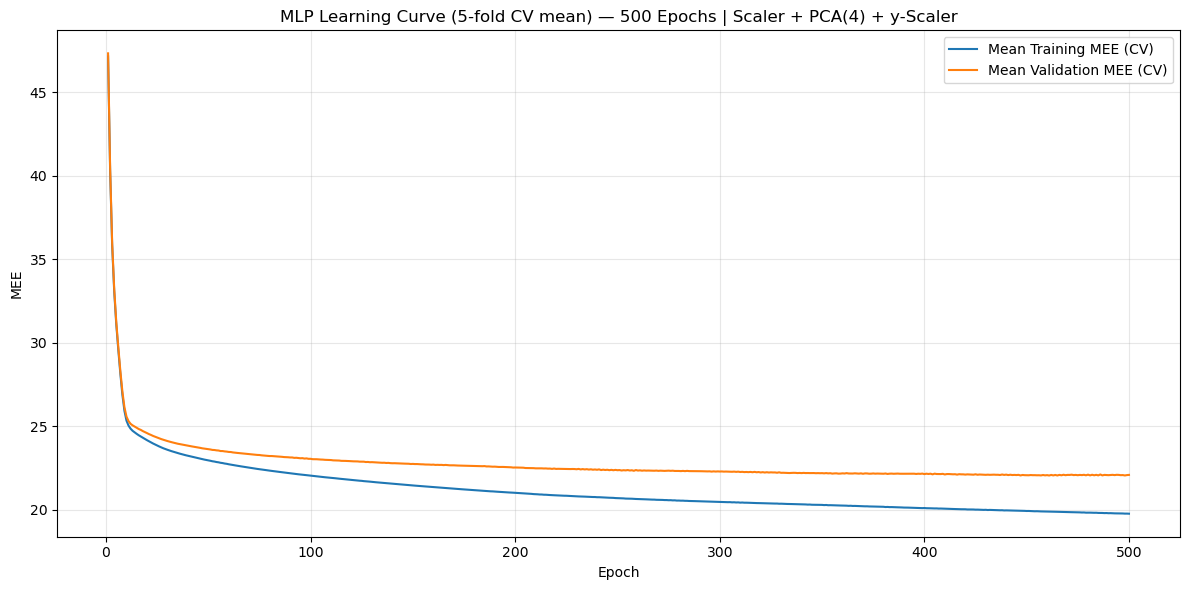

In [18]:
train_mean, val_mean = mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    mlp_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4
)

import matplotlib.pyplot as plt
epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

In [19]:
param_grid_stage1 = {
    "regressor__mlp__hidden_layer_sizes": [(8,), (12,), (16,), (32, 16), (16, 16), (16, 8), (4, 4)],
    "regressor__mlp__batch_size": [32, 64, 128],
    "regressor__mlp__learning_rate_init": [5e-4, 1e-3, 1e-4],
    "regressor__mlp__learning_rate": ["adaptive"],   
    "regressor__mlp__momentum": [0.5, 0.7, 0.9],
    "regressor__mlp__nesterovs_momentum": [True],
    "regressor__mlp__alpha": [0.01, 0.05, 0.1, 0.2, 0.5],
}

In [20]:
# 1) Bạn cần có X, y (y shape: (n,4))
# X, y = ...

X_dev, X_int, y_dev, y_int = split_dev_internal(X, y, test_size=0.2, random_state=42)

cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42)

# Khuyến nghị: để PCA trong pipeline để CV không leakage
model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

# ---- Stage 1 ----
gs1 = run_grid_search(model, param_grid_stage1, X_dev, y_dev, cv5, verbose=1)

# ---- Stage 2 (refine) ----
#grid2 = param_grid_refine(gs1.best_params_)
#gs2 = run_grid_search(gs1.best_estimator_, grid2, X_dev, y_dev, cv5, verbose=1)

# ---- Evaluate internal once ----
eval_internal(gs1.best_estimator_, X_int, y_int)

Dev     : (400, 12) (400, 4)
Internal: (100, 12) (100, 4)
Fitting 5 folds for each of 945 candidates, totalling 4725 fits
Best params: {'regressor__mlp__alpha': 0.1, 'regressor__mlp__batch_size': 32, 'regressor__mlp__hidden_layer_sizes': (32, 16), 'regressor__mlp__learning_rate': 'adaptive', 'regressor__mlp__learning_rate_init': 0.001, 'regressor__mlp__momentum': 0.9, 'regressor__mlp__nesterovs_momentum': True}
Best CV MEE : 23.457523559684194
Internal MEE: 23.618487464428327


23.618487464428327

## phase 2

In [21]:
param_grid_stage1 = {
    "regressor__mlp__hidden_layer_sizes": [(4,), (16, 16), (16, 8), (4, 4), (8,4)],
    "regressor__mlp__batch_size": [32, 64, 96, 128],
    "regressor__mlp__learning_rate_init": [5e-4, 1e-3, 1e-4],
    "regressor__mlp__learning_rate": ["adaptive"],   
    "regressor__mlp__momentum": [0.5, 0.7, 0.9],
    "regressor__mlp__nesterovs_momentum": [True],
    "regressor__mlp__alpha": [0.01, 0.05, 0.1, 0.2, 0.5],
}

In [22]:
X_dev, X_int, y_dev, y_int = split_dev_internal(X, y, test_size=0.2, random_state=42)

cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42)

model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

gs1 = run_grid_search(model, param_grid_stage1, X_dev, y_dev, cv5, verbose=1)

# ---- Evaluate internal once ----
eval_internal(gs1.best_estimator_, X_int, y_int)

Dev     : (400, 12) (400, 4)
Internal: (100, 12) (100, 4)
Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Best params: {'regressor__mlp__alpha': 0.05, 'regressor__mlp__batch_size': 32, 'regressor__mlp__hidden_layer_sizes': (16, 16), 'regressor__mlp__learning_rate': 'adaptive', 'regressor__mlp__learning_rate_init': 0.001, 'regressor__mlp__momentum': 0.9, 'regressor__mlp__nesterovs_momentum': True}
Best CV MEE : 23.852768052745354
Internal MEE: 23.889629774510645


23.889629774510645

In [24]:
MLP_BEST = extract_mlp_params(gs1.best_params_)
MLP_BEST

{'alpha': 0.05,
 'batch_size': 32,
 'hidden_layer_sizes': (16, 16),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'momentum': 0.9,
 'nesterovs_momentum': True}

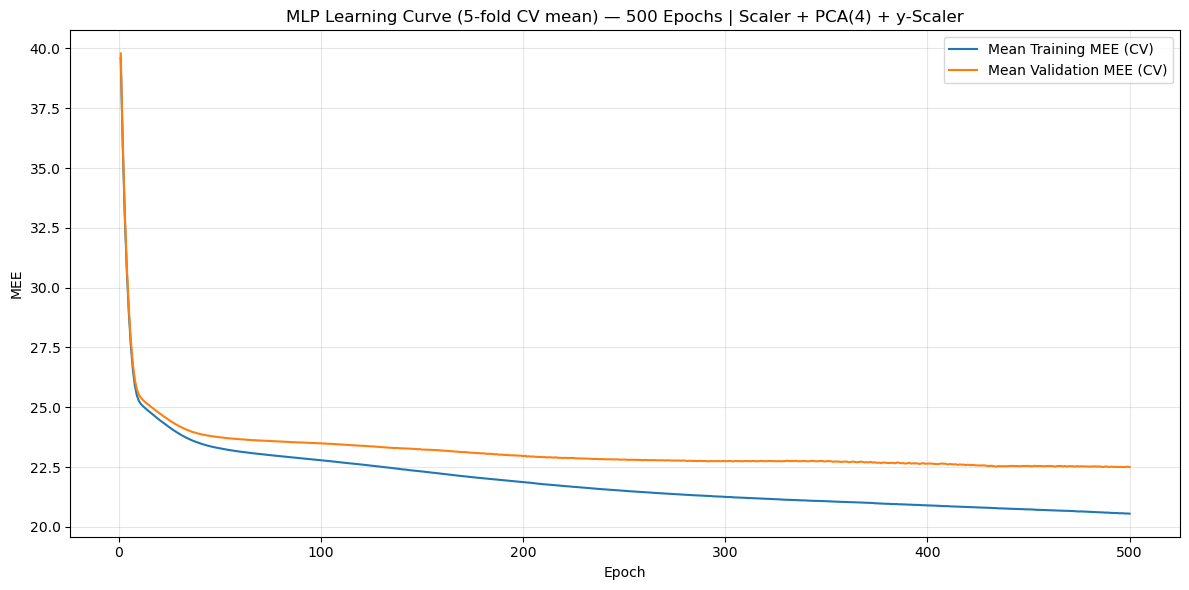

In [25]:
train_mean, val_mean = mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    mlp_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4
)

import matplotlib.pyplot as plt
epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

## phase 3: only 1 layer model

In [26]:
param_grid_stage1 = {
    "regressor__mlp__hidden_layer_sizes": [(4,), (6,), (8,), (16,)],
    "regressor__mlp__batch_size": [32, 64, 96, 128],
    "regressor__mlp__learning_rate_init": [5e-4, 1e-3, 1e-4],
    "regressor__mlp__learning_rate": ["adaptive"],   
    "regressor__mlp__momentum": [0.5, 0.7, 0.9],
    "regressor__mlp__nesterovs_momentum": [True],
    "regressor__mlp__alpha": [0.01, 0.05, 0.1, 0.2, 0.5],
}

In [27]:
X_dev, X_int, y_dev, y_int = split_dev_internal(X, y, test_size=0.2, random_state=42)

cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42)

model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

gs1 = run_grid_search(model, param_grid_stage1, X_dev, y_dev, cv5, verbose=1)

# ---- Evaluate internal once ----
eval_internal(gs1.best_estimator_, X_int, y_int)

Dev     : (400, 12) (400, 4)
Internal: (100, 12) (100, 4)
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Best params: {'regressor__mlp__alpha': 0.05, 'regressor__mlp__batch_size': 32, 'regressor__mlp__hidden_layer_sizes': (16,), 'regressor__mlp__learning_rate': 'adaptive', 'regressor__mlp__learning_rate_init': 0.001, 'regressor__mlp__momentum': 0.9, 'regressor__mlp__nesterovs_momentum': True}
Best CV MEE : 24.097913904660043
Internal MEE: 23.890696501317915


23.890696501317915

In [28]:
MLP_BEST = extract_mlp_params(gs1.best_params_)
MLP_BEST

{'alpha': 0.05,
 'batch_size': 32,
 'hidden_layer_sizes': (16,),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'momentum': 0.9,
 'nesterovs_momentum': True}

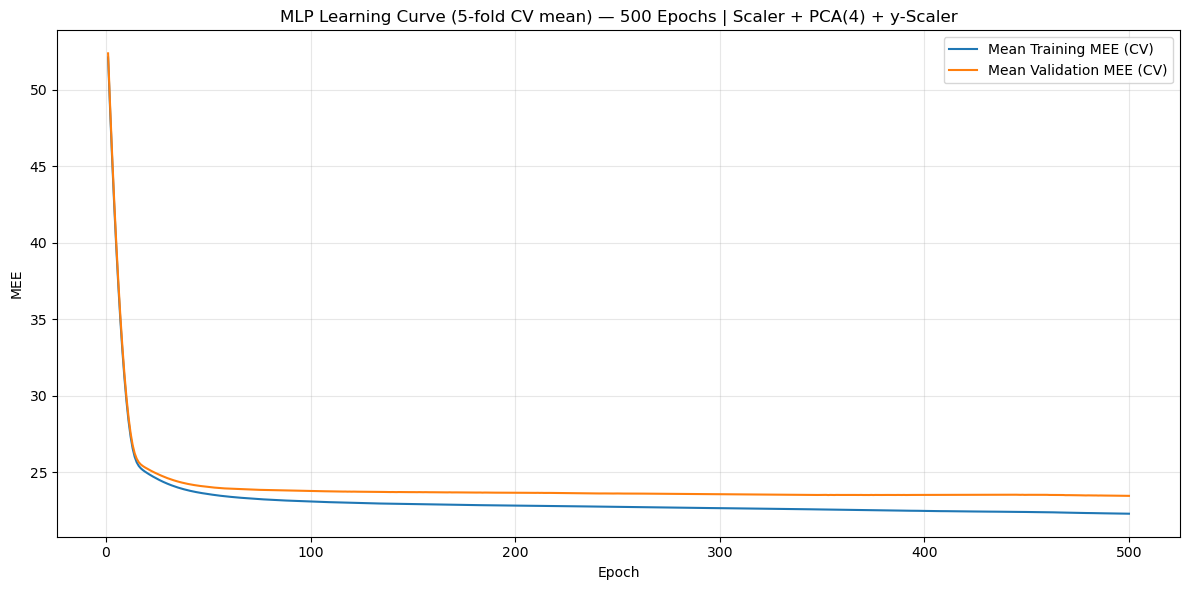

In [29]:
train_mean, val_mean = mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    mlp_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4
)

import matplotlib.pyplot as plt
epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

## phase 4: activation tuning with best models from previous tuning

In [11]:
param_grid_stage1 = {
    "regressor__mlp__hidden_layer_sizes": [(8,), (16,)],
    "regressor__mlp__activation": ["relu", "tanh"],  
    "regressor__mlp__batch_size": [32, 64, 96, 128],
    "regressor__mlp__learning_rate_init": [5e-4, 1e-3, 1e-4],
    "regressor__mlp__learning_rate": ["adaptive"],
    "regressor__mlp__momentum": [0.5, 0.7, 0.9],
    "regressor__mlp__nesterovs_momentum": [True],
    "regressor__mlp__alpha": [0.05, 0.1, 0.2, 0.5],
}

In [14]:
X_dev, X_int, y_dev, y_int = split_dev_internal(X, y, test_size=0.2, random_state=42)

cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42)

model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

gs1 = run_grid_search(model, param_grid_stage1, X_dev, y_dev, cv5, verbose=1)

# ---- Evaluate internal once ----
eval_internal(gs1.best_estimator_, X_int, y_int)

Dev     : (400, 12) (400, 4)
Internal: (100, 12) (100, 4)
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best params: {'regressor__mlp__activation': 'tanh', 'regressor__mlp__alpha': 0.1, 'regressor__mlp__batch_size': 32, 'regressor__mlp__hidden_layer_sizes': (8,), 'regressor__mlp__learning_rate': 'adaptive', 'regressor__mlp__learning_rate_init': 0.001, 'regressor__mlp__momentum': 0.9, 'regressor__mlp__nesterovs_momentum': True}
Best CV MEE : 23.866878973015993
Internal MEE: 24.316432494840072


24.316432494840072

In [17]:
MLP_BEST = extract_mlp_params(gs1.best_params_)
MLP_BEST

{'activation': 'tanh',
 'alpha': 0.1,
 'batch_size': 32,
 'hidden_layer_sizes': (8,),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'momentum': 0.9,
 'nesterovs_momentum': True}

C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\U

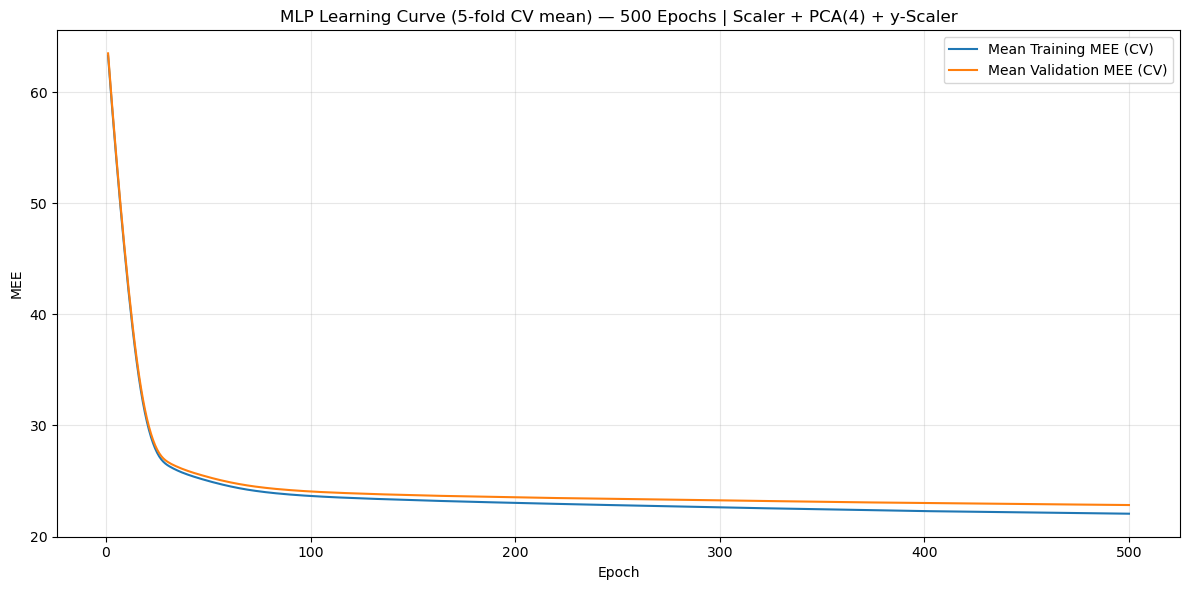

In [20]:
train_mean, val_mean = mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    mlp_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4
)

import matplotlib.pyplot as plt
epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

## phase 5: add 2 layers

In [23]:
param_grid_stage1 = {
    "regressor__mlp__hidden_layer_sizes": [(8,), (16,), (16,16), (32,16)],
    "regressor__mlp__activation": ["relu", "tanh"],  
    "regressor__mlp__batch_size": [32, 64, 96, 128],
    "regressor__mlp__learning_rate_init": [5e-4, 1e-3, 1e-4],
    "regressor__mlp__learning_rate": ["adaptive"],
    "regressor__mlp__momentum": [0.9],
    "regressor__mlp__nesterovs_momentum": [True],
    "regressor__mlp__alpha": [0.1, 0.2, 0.5],
}

In [24]:
X_dev, X_int, y_dev, y_int = split_dev_internal(X, y, test_size=0.2, random_state=42)

cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42)

model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

gs1 = run_grid_search(model, param_grid_stage1, X_dev, y_dev, cv5, verbose=1)

# ---- Evaluate internal once ----
eval_internal(gs1.best_estimator_, X_int, y_int)

Dev     : (400, 12) (400, 4)
Internal: (100, 12) (100, 4)
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best params: {'regressor__mlp__activation': 'relu', 'regressor__mlp__alpha': 0.1, 'regressor__mlp__batch_size': 32, 'regressor__mlp__hidden_layer_sizes': (32, 16), 'regressor__mlp__learning_rate': 'adaptive', 'regressor__mlp__learning_rate_init': 0.001, 'regressor__mlp__momentum': 0.9, 'regressor__mlp__nesterovs_momentum': True}
Best CV MEE : 23.457523559684194
Internal MEE: 23.618487464428327


C:\Users\manht\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


23.618487464428327

In [25]:
MLP_BEST = extract_mlp_params(gs1.best_params_)
MLP_BEST

{'activation': 'relu',
 'alpha': 0.1,
 'batch_size': 32,
 'hidden_layer_sizes': (32, 16),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'momentum': 0.9,
 'nesterovs_momentum': True}

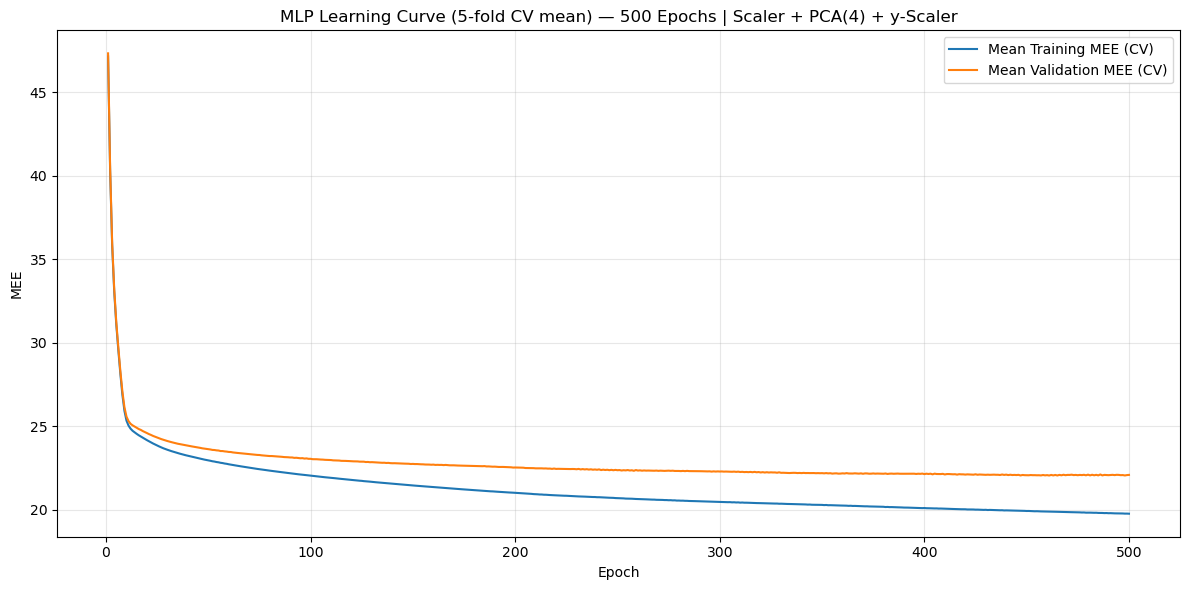

In [28]:
train_mean, val_mean = mlp_learning_curve_5fold_cv_mean_only(
    X_dev, y_dev,
    mlp_params=MLP_BEST,
    epochs=500,
    cv=cv5,
    random_state=42,
    pca_components=4
)

import matplotlib.pyplot as plt
epochs = np.arange(1, 501)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_mean, label="Mean Training MEE (CV)")
plt.plot(epochs, val_mean,   label="Mean Validation MEE (CV)")
plt.xlabel("Epoch"); plt.ylabel("MEE")
plt.title("MLP Learning Curve (5-fold CV mean) — 500 Epochs | Scaler + PCA(4) + y-Scaler")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

In [30]:
param_grid_stage1 = {
    "regressor__mlp__hidden_layer_sizes": [(8,), (16,)],
    "regressor__mlp__activation": ["relu", "tanh"],  
    "regressor__mlp__batch_size": [64, 96, 128],
    "regressor__mlp__learning_rate_init": [5e-4, 1e-3, 1e-4],
    "regressor__mlp__learning_rate": ["adaptive"],
    "regressor__mlp__momentum": [0.5, 0.7, 0.9],
    "regressor__mlp__nesterovs_momentum": [True],
    "regressor__mlp__alpha": [0.1, 0.2, 0.5],
}

In [31]:
X_dev, X_int, y_dev, y_int = split_dev_internal(X, y, test_size=0.2, random_state=42)

cv5 = make_cv5(42)

cfg = MLPConfig(max_iter=500, random_state=42)

model = build_mlp_ttr(cfg, use_pca=True, pca_components=4)

gs1 = run_grid_search(model, param_grid_stage1, X_dev, y_dev, cv5, verbose=1)

# ---- Evaluate internal once ----
eval_internal(gs1.best_estimator_, X_int, y_int)

Dev     : (400, 12) (400, 4)
Internal: (100, 12) (100, 4)
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best params: {'regressor__mlp__activation': 'tanh', 'regressor__mlp__alpha': 0.1, 'regressor__mlp__batch_size': 64, 'regressor__mlp__hidden_layer_sizes': (8,), 'regressor__mlp__learning_rate': 'adaptive', 'regressor__mlp__learning_rate_init': 0.001, 'regressor__mlp__momentum': 0.9, 'regressor__mlp__nesterovs_momentum': True}
Best CV MEE : 24.193902076290975
Internal MEE: 24.519647081721217


24.519647081721217